Archive:  ./img-CB55.zip
replace img/public-test/e-codices_fmb-cb-0055_0098v_max.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: img/public-test/e-codices_fmb-cb-0055_0098v_max.jpg  
  inflating: img/public-test/e-codices_fmb-cb-0055_0099v_max.jpg  
 extracting: img/public-test/e-codices_fmb-cb-0055_0102v_max.jpg  
  inflating: img/public-test/e-codices_fmb-cb-0055_0105r_max.jpg  
 extracting: img/public-test/e-codices_fmb-cb-0055_0107v_max.jpg  
 extracting: img/public-test/e-codices_fmb-cb-0055_0108v_max.jpg  
  inflating: img/public-test/e-codices_fmb-cb-0055_0116r_max.jpg  
 extracting: img/public-test/e-codices_fmb-cb-0055_0159v_max.jpg  
  inflating: img/public-test/e-codices_fmb-cb-0055_0160v_max.jpg  
 extracting: img/public-test/e-codices_fmb-cb-0055_0162v_max.jpg  
  inflating: img/training/e-codices_fmb-cb-0055_0005v_max.jpg  
  inflating: img/training/e-codices_fmb-cb-0055_0008v_max.jpg  
 extracting: img/training/e-codices_fmb-cb-0055_0011r_max.jpg  
  inflating:

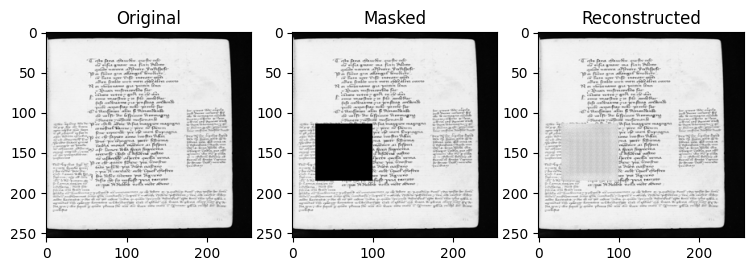

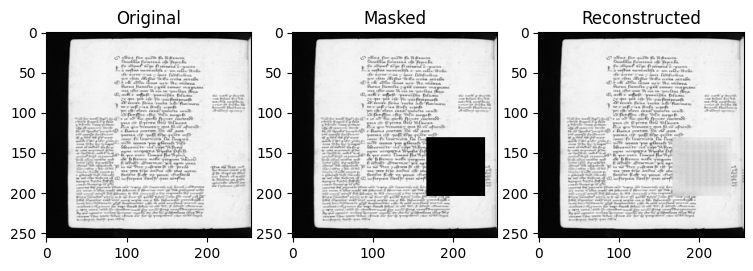

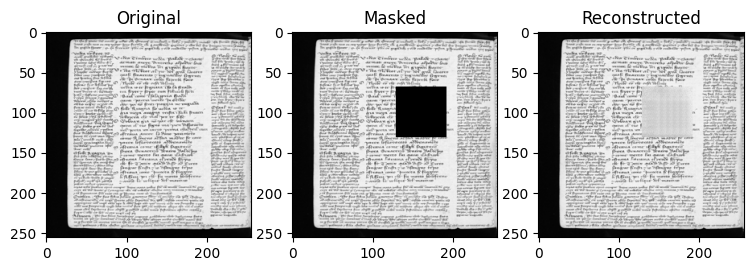

In [11]:
# Import all libs needed
# !unzip ./img-CB55.zip
# Install any missing dependencies if not running on Google Colab
# !pip install torch torchvision matplotlib numpy pillow scikit-image

import os, random
import numpy as np
# import image and plot
from PIL import Image
import matplotlib.pyplot as plt

# import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# To calculate PSNR without writing the equation in code.
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

#Dataset with block masking
class DocumentInpaintingDataset(Dataset):
    def init(self, img_dir, patch_size=256, mask_type='irregular'):
        super().init()
        self.img_paths = []
        for f in os.listdir(img_dir):
            # Convert filename to lowercase and check if it ends with '.jpg'
            if f.lower().endswith('.jpg'):
                # Construct full path and add to list
                full_path = os.path.join(img_dir, f)
                self.img_paths.append(full_path)
        # if forgot put database into colab again
        if not self.img_paths:
            raise FileNotFoundError(f"No images found in {img_dir}")
        self.patch_size = patch_size
        self.mask_type  = mask_type
    # length was used for previous test try to limit pictures
    def len(self):
        return len(self.img_paths)

    # put random mask on the picture as holes and missing pieces
    def random_mask(self):
        H = W = self.patch_size
        mask = np.ones((H, W), dtype=np.float32)

        if self.mask_type == 'center':
            s = H // 2
            start = (H - s) // 2
            mask[start:start+s, start:start+s] = 0
        # calling a bunch of random int that is divisinle in a 256*256 pic
        # some back and forth to find a "tear and missing mask" with GenAI
        elif self.mask_type == 'random':
            s = random.randint(H // 8, H // 2)
            x = random.randint(0, H - s - 1)
            y = random.randint(0, W - s - 1)
            mask[y:y+s, x:x+s] = 0

        else:
            # multiple random blocks
            for _ in range(random.randint(1, 5)):
                s = random.randint(H // 8, H // 3)
                x = random.randint(0, H - s - 1)
                y = random.randint(0, W - s - 1)
                mask[y:y+s, x:x+s] = 0

        return mask
    # get picture to model
    def getitem(self, idx):
        img = Image.open(self.img_paths[idx]).convert('L')
        # Resize the image to the desired patch size
        img = img.resize((self.patch_size, self.patch_size))
        # Convert the image to grey scale that normalized
        img_np = np.array(img, dtype=np.float32) / 255.0
        # mask is multiplying 0s to the value to make it blank
        mask = self.randomasked_img()
        masked = img_np * mask
        # 3 image for result
        return (
            torch.from_numpy(masked).unsqueeze(0),
            torch.from_numpy(mask).unsqueeze(0),
            torch.from_numpy(img_np).unsqueeze(0)
        )

# Channel wise fully connected layer
class ChannelWiseFC(nn.Module):
    def init(self, num_channels):
        super().init()
        # Create a learnable weight vector, one per input channel, initialized to 1
        self.weights = nn.Parameter(torch.ones(num_channels))
    def forward(self, x):
        # Reshapes the weights to [1, C, 1, 1] so can be broadcast across batch, height, and width.
        # Multiply each channel of the input tensor by its corresponding weight
        return x * self.weights.view(1,-1,1,1)

# Very basic recreation of model and using technique from coursework
class ContextEncoder(nn.Module):
    def init(self):
        super().init()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.fc = ChannelWiseFC(512)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, mask):
        # Encode the masked input after applying mask
        feat = self.encoder(x * mask)
        # Apply channel-wise scaling
        feat = self.fc(feat)
        # Decode the feature map to reconstruct the missing regions
        out  = self.decoder(feat)
         # Apply the inverse of the mask to keep only the predicted regions
        return out * (1 - mask)

# Train and Validation definition
def train_one_epoch(model, loader, opt, crit, dev):
    model.train()
    running = 0
    # Loop over all batches in the DataLoader
    for in_img, masked_img, gt in loader:
        # Move the masked image, mask, and ground truth
        in_img, masked_img, gt = in_img.to(dev), masked_img.to(dev), gt.to(dev)
        # Reset gradients from the previous step
        opt.zero_grad()
        # fp
        pred = model(in_img, masked_img)
        loss = crit(pred, gt * (1 - masked_img))
        # Backpropagate gradients
        loss.backward()
        opt.step()
        # Accumulate the batch loss, scaled by the number of images in the batch
        running += loss.item() * in_img.size(0)
    # Return the average loss over the entire dataset
    return running / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = total_psnr = 0
    with torch.no_grad():
      # Iterate over the validation DataLoader
      for masked, mask, target in loader:
          masked, mask, target = [t.to(device) for t in (masked, mask, target)]
          # Get predicted inpainting
          pred = model(masked, mask)
          # loss only on the masked region
          total_loss += criterion(pred, target * (1 - mask)).item() * masked.size(0)

          # Convert tensors to numpy arrays for PSNR calculation
          gt_full  = target.cpu().numpy()[0,0]
          # convert using CPU
          rec_full = (masked + pred).cpu().numpy()[0,0]
          m = mask.cpu().numpy()[0,0]
          # Compute PSNR only on the masked
          total_psnr += compare_psnr(gt_full[m==0], rec_full[m==0], data_range=1.0)

    n = len(loader.dataset)
    return total_loss/n, total_psnr/n

# Training
if __name__ == '__main__':
    # Define dataset directories
    TRAIN_DIR = './img/training'
    VAL_DIR = './img/validation'
    TEST_DIR = './img/public-test'

    # Verify that all required directories exist
    for D in (TRAIN_DIR, VAL_DIR, TEST_DIR):
        if not os.path.isdir(D):
            raise FileNotFoundError(f"Missing directory: {D}")

    # Training configuration
    PATCH_SIZE = 256
    BATCH_SIZE = 16
    LR = 1e-4
    EPOCHS = 50
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load datasets
    train_ds = DocumentInpaintingDataset(TRAIN_DIR, PATCH_SIZE, 'irregular')
    val_ds = DocumentInpaintingDataset(VAL_DIR, PATCH_SIZE, 'irregular')
    test_ds = DocumentInpaintingDataset(TEST_DIR, PATCH_SIZE, 'irregular')

    # Create DataLoaders
    train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_ds, 1, shuffle=False, num_workers=2)

    # Initialize model, optimizer, and loss function
    model = ContextEncoder().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    # Training loop
    for ep in range(1, EPOCHS + 1):
        trl = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
        vl, ps = validate(model, val_loader, criterion, DEVICE)
        print(f"Epoch {ep:02d} | Train Loss={trl:.4f} | Val Loss={vl:.4f} | Val PSNR={ps:.2f}")

    # Save the trained model
    torch.save(model.state_dict(), 'context_encoder_cb55_nossim.pth')


# Result show
model.eval()
with torch.no_grad():
    for i, (masked_img, mask, ground_truth) in enumerate(test_loader):
        masked_img, mask = masked_img.to(DEVICE), mask.to(DEVICE)

        # Generate prediction and reconstruct image
        prediction = model(masked_img, mask).cpu()
        reconstructed = masked_img.cpu()[0, 0] + prediction[0, 0]

        # Visualize the first 3 relics
        if i < 3:
            fig, axes = plt.subplots(1, 3, figsize=(10, 3))

            axes[0].imshow(ground_truth[0, 0], cmap='gray')
            axes[0].set_title('Original')
            axes[0].axis('off')

            axes[1].imshow(masked_img.cpu()[0, 0], cmap='gray')
            axes[1].set_title('Masked')
            axes[1].axis('off')

            axes[2].imshow(reconstructed, cmap='gray')
            axes[2].set_title('Reconstructed')
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()
        else:
            break



# FROM https://github.com/yeungchenwa/HDR by paper Predicting the Original Appearance of Damaged Historical Documents

In [4]:
%cd /content/HDR
!pip install huggingface_hub==0.12.1
!sh /content/HDR/scripts/inference.sh

/content/HDR
Traceback (most recent call last):
  File "/content/HDR/inference.py", line 8, in <module>
    from transformers import set_seed
  File "/usr/local/lib/python3.11/dist-packages/transformers/__init__.py", line 27, in <module>
    from . import dependency_versions_check
  File "/usr/local/lib/python3.11/dist-packages/transformers/dependency_versions_check.py", line 16, in <module>
    from .utils.versions import require_version, require_version_core
  File "/usr/local/lib/python3.11/dist-packages/transformers/utils/__init__.py", line 20, in <module>
    from huggingface_hub.constants import HF_HUB_DISABLE_TELEMETRY as DISABLE_TELEMETRY  # for backward compatibility
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ImportError: cannot import name 'HF_HUB_DISABLE_TELEMETRY' from 'huggingface_hub.constants' (/usr/local/lib/python3.11/dist-packages/huggingface_hub/constants.py)


In [7]:
# !git clone https://github.com/yeungchenwa/HDR.git
# !pip install -r ./HDR/requirements.txt
# !pip install --upgrade diffusers==0.20.2 transformers accelerate safetensors

import argparse, os
import numpy as np
import torch
from torchvision.transforms import functional as F
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from transformers import set_seed

# make sure src/ is on your PYTHONPATH so that `from src.build_HDR import build_pipeline` works
from src.build_HDR import build_pipeline

# 1) Prepare an args object exactly as inference.py expects
hdr_args = argparse.Namespace(
    seed=123,
    device='cuda:0' if torch.cuda.is_available() else 'cpu',
    save_dir=None,
    ckpt_path='ckpt/unet',          # point to your downloaded checkpoint
    image_channel=3,
    pipeline='DPM-Solver',
    classifier_free=True,
    content_mask_guidance_scale=1.5,
    degraded_guidance_scale=1.2,
    solver_order=2,
    num_inference_steps=20,
    ddpm_num_steps=1000,
    ddpm_beta_schedule='linear',
    prediction_type='sample',
    image_path=None,
    mask_image_path=None,
    content_image_path=None
)

# 2) Build UNet and the HDR diffusion pipeline
set_seed(hdr_args.seed)
unet = UNet2DModel.from_pretrained(hdr_args.ckpt_path).to(hdr_args.device)
pipeline = build_pipeline(args=hdr_args, unet=unet).to(hdr_args.device)
pipeline.eval()

# 3) Utility to run HDR inference on one batch
def inpaint_hdr(degraded_tensor, mask_tensor, content_tensor):
    # the pipeline expects:
    #  - degraded_image: RGB tensor in [-1,+1]
    #  - char_mask_image: 1-channel mask in [-1,+1]
    #  - content_image: 1-channel content in [-1,+1]
    out = pipeline(
        degraded_image=degraded_tensor,
        char_mask_image=mask_tensor,
        content_image=content_tensor,
        image_channel=hdr_args.image_channel,
        classifier_free=hdr_args.classifier_free,
        content_mask_guidance_scale=hdr_args.content_mask_guidance_scale,
        degraded_guidance_scale=hdr_args.degraded_guidance_scale,
        generator=torch.Generator(device=hdr_args.device).manual_seed(hdr_args.seed),
        batch_size=1,
        num_inference_steps=hdr_args.num_inference_steps,
        output_type='np'   # return a NumPy array
    )
    # returns array shape (1, H, W, 3) if RGB; we take the first channel
    return out[0,...,0]

# 4) Evaluate PSNR on your val_loader
total_psnr, count = 0.0, 0
device = hdr_args.device

with torch.no_grad():
    for masked_t, mask_t, target_t in val_loader:
        # expand grayscale → 3-channel by repeating, and normalize to [-1,+1]
        deg = F.to_tensor(masked_t.numpy()[0,0]).repeat(3,1,1).unsqueeze(0)
        msk = F.to_tensor(mask_t.numpy()[0,0]).unsqueeze(0)   # stays 1-channel
        cnt = F.to_tensor(target_t.numpy()[0,0]).unsqueeze(0) # 1-channel
        # normalize
        deg = (deg - 0.5) / 0.5
        msk = (msk - 0.5) / 0.5
        cnt = (cnt - 0.5) / 0.5

        deg = deg.to(device)
        msk = msk.to(device)
        cnt = cnt.to(device)

        pred = inpaint_hdr(deg, msk, cnt)   # H×W array in [0,1]
        gt   = target_t.numpy()[0,0]

        hole = (mask_t.numpy()[0,0] == 0)
        total_psnr += compare_psnr(gt[hole], pred[hole], data_range=1.0)
        count += 1

baseline_psnr = total_psnr / count
print(f"DiffHDR Baseline (official inference) → PSNR: {baseline_psnr:.2f} dB")


ModuleNotFoundError: No module named 'src'